# The game of Slap

## [Fiddler, Oct. 13, 2023](https://thefiddler.substack.com/p/can-you-throw-the-card-game)

> Every so often, I play the card game Slap with someone who really doesn’t like to lose. (You know who you are.) But before we get into all that, here are the rules of the game:
>
> Two players are both dealt 26 cards from a standard deck. From there, they take turns putting down one card at a time. Let’s interchangeably designate the players as “A” and “B.”
>
> - If A puts down a jack, then B puts down one card. If it’s a face card, the game continues with A. Otherwise, A wins the round and adds those cards to the bottom of their pile so that the last card played is at the very bottom of the pile.
> - If A puts down a queen, B has two chances to put down a face card, at which point the game would continue with A. Otherwise, A wins the round and collects the cards.
> - If A puts down a king, B has three chances to put down a face card, at which point the game would continue with A. Otherwise, A wins the round and collects the cards.
> - If A puts down an ace, B has four chances to put down a face card, at which point the game would continue with A. Otherwise, A wins the round and collects the cards.
> - If, at any point, two cards have been played in succession (by different players or the same player) that have the same number or face, then both players can slap the pile of played cards to win the round and collect the cards.
> - Whoever won the previous round plays the first card in the next round.
>
> It turns out that rigging the deck while shuffling is very hard to do. Instead, I decide to cheat in my opponent’s favor by ensuring my reaction time is slower than theirs at every single slapping opportunity. In other words, I lose every slap.
> Assuming I shuffle and distribute the cards randomly, and that my opponent plays the first card in the game, what is my probability of winning?

### Solution by [Laurent Lessard](https://laurentlessard.com)

In my code, I assumed there were $N$ players. In this more general version of Slap, there are additional rules:
- Play proceeds in a clockwise fashion
- When a player runs out of cards, they remain part of the game. They can get back in by winning a "slap".
- If a player challenges (plays a face card), the next player must meet that challenge. If that player meets the challenge (plays a face card in time), they become the new challenger and now the next player in clockwise order must meet the challenge.
- If a player runs out of cards mid-challenge, the next player in order continues with the challenge.
- I assumed one player (Player 0) always loses every slap; every other player has an equal chance of winning.
- I assumed that a random player is chosen to go first.
- I assumed that cards are dealt such that every player has the same number of cards and the rest are discarded. (e.g. in a 5-player game, each player would get 10 cards and the remaining 2 cards would be excluded from the deck).

I investigated and found:
- The probability of winning for each player. It turns out you are far less likely to win (10-15 times less likely) if you purposefully lose every slap.
- The duration of matches. This generally increases as we add more players, but there are some irregularities due to the fact that the number of cards each player starts with changes. e.g. in going from $N=10$ to $N=11$, we go from $5$ cards/player to $4$ cards/player; a dramatic reduction. This causes games to get a lot shorter on average.

## Helper functions

In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt

# Define the deck of cards
ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
attempt_map = {'J':1, 'Q':2, 'K':3, 'A':4}
faces = ['J', 'Q', 'K', 'A']
deck = [{'rank': rank, 'suit': suit} for rank in ranks for suit in suits]
pile = []
playing = []
hand = []

# various counters
current_turn = 0
challenge = False
attempts_remaining = 0
winner = None

def next(i):
    N = len(playing)
    for j in range(i+1,i+N):
        if playing[j % N]:
            return j % N
        
def prev(i):
    N = len(playing)
    for j in range(i-1,i-N,-1):
        if playing[j % N]:
            return j % N

# check for doubles (player 0 always loses the slap!)
def slap():
    global current_turn
    global challenge
    if len(pile) >= 2 and pile[-1]['rank'] == pile[-2]['rank']:
        i = random.randint(1, len(playing) - 1)
        # print(f"SLAP! Player {i} wins the pile!")
        hand[i].extend(pile)
        playing[i] = True
        pile.clear()
        current_turn = i
        challenge = False
        return True
    else:
        return False

# player i plays a card
def play_card(i):
    card = hand[i].pop(0)
    # print(f"Player {i} plays: {card['rank']} of {card['suit']}")
    pile.append(card)
    return card
        
# check to see if player i is out of cards, and whether the game is over or not.
def check_win(i):
    global winner
    global current_turn
    if not hand[i]:
        # print(f"Player {i} is out of cards, they're out for now")
        playing[i] = False
        
    # if only one player remaining, they win!
    if playing.count(True) == 1:
        winner = playing.index(True)
        # print(f"Player {winner} has won the game!")
        # print(playing)
        return True
    else:
        return False

def print_status():
    print( f"Currently player turn: {current_turn}" )
    print( f"Who is playing? {playing}" )
    for i in len(playing):
        print( f"Hand {i}: {[card['rank'] for card in hand[i]]}" )
    print( f"Pile: {[card['rank'] for card in pile]}" )
    print( f"Challenge? {challenge}" )
    

# Main game loop. Play a game with N players
def play_game(N):
    
    global current_turn 
    global challenge
    global attempts_remaining
    global playing
    
    # deal cards to N players (discard extras)
    random.shuffle(deck)
    cards_per_player = len(deck) // N
    hand.clear()
    for i in range(N):
        hand.append( deck[i * cards_per_player:(i + 1) * cards_per_player] )

    current_turn = random.randint(0,N-1)
    playing = [True] * N
    challenge = False
    attempts_remaining = 0
    
    for turn in range(100000):
                
        if not playing[current_turn]:
            print_status()
            
        card = play_card(current_turn)
                    
        if check_win(current_turn):
            break
        if slap():
            continue
            
        if challenge:
            if card['rank'] in faces:
                # challenger beat the challenge, passes on to next player
                attempts_remaining = attempt_map[card['rank']]
                # print(f"Player {current_turn} is challenging with a {card['rank']}, {attempts_remaining} attempts remaining.")
                current_turn = next(current_turn)
                continue
            else:
                attempts_remaining -= 1
                if attempts_remaining == 0:
                    # they did not beat the challenge, challenger takes the pile
                    i = prev(current_turn)
                    # print(f"Challenger (Player {i}) wins the challenge.")
                    hand[i].extend(pile)
                    playing[i] = True
                    pile.clear()
                    current_turn = i
                    challenge = False
                else:
                    # they just keep going. But if they're out of cards, the next person takes their place
                    if not playing[current_turn]:
                        current_turn = next(current_turn)
        else:
            if card['rank'] in faces:
                challenge = True
                attempts_remaining = attempt_map[card['rank']]
                # print(f"Player {current_turn} is challenging with a {card['rank']}, {attempts_remaining} attempts remaining.")
            
            current_turn = next(current_turn)
            continue
    return (winner, turn)

## Monte Carlo simulation (time-consuming)

In [12]:
%%time

random.seed(1)

M = 100000 # 1000 = 0:45, 10000 = 7:41

expt = []
for N in range(2,14):    
    print(f"Currently on Experiment {N}")
    counts = [0] * N
    turns = []
    for _ in range(M):
        i,t = play_game(N)
        counts[i] += 1
        turns.append(t)
    expt.append( (N,M,counts,turns) )

Currently on Experiment 2
Currently on Experiment 3
Currently on Experiment 4
Currently on Experiment 5
Currently on Experiment 6
Currently on Experiment 7
Currently on Experiment 8
Currently on Experiment 9
Currently on Experiment 10
Currently on Experiment 11
Currently on Experiment 12
Currently on Experiment 13
CPU times: total: 1h 11min 9s
Wall time: 4h 40min 51s


## Show empirical probability distribution

Probabilities: [0.0119 0.2489 0.2478 0.2461 0.2454]
       Errors: [0.0007 0.0027 0.0027 0.0027 0.0027]
   Mean turns: 965.16


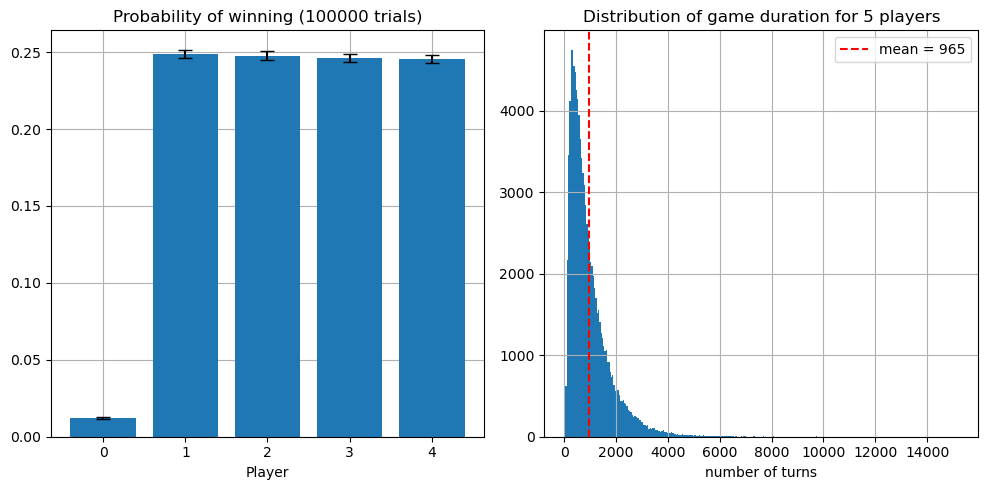

In [51]:
def plot_results(N,M,counts,turns):
    probs = np.array(counts) / M
    z = 1.96 # z-score for 95% confidence
    errors = [ z * np.sqrt(p * (1 - p) / M + z**2 / (4 * M**2)) for p in probs ]
    m = np.mean(turns)
    print(f"Probabilities: {np.round(probs,4)}")
    print(f"       Errors: {np.round(errors,4)}")
    print(f"   Mean turns: {round(m,2)}")

    
    fig,axs = plt.subplots(1,2, figsize=(10,5))
    
    plt.sca(axs[0])
    plt.bar(range(N), probs, yerr=errors, capsize=5, zorder=2)
    plt.xticks(range(N))
    plt.title(f"Probability of winning ({M} trials)")
    plt.xlabel("Player")
    plt.grid(zorder = 1)
    
    plt.sca(axs[1])
    plt.hist(turns,range(0,np.max(turns),50),density=False)
    plt.axvline(x=m, color='red', linestyle='--', label=f'mean = {m:.0f}')
    plt.grid()
    plt.title(f"Distribution of game duration for {N} players")
    plt.xlabel("number of turns")
    plt.legend()
    
    fig.tight_layout()
    return fig
    
fig = plot_results(*expt[5 - 2])
# fig.savefig('slap13.png')

## Compare statistics as we change number of players

1
2
3
4
5
6
7
8
9
10
11
12


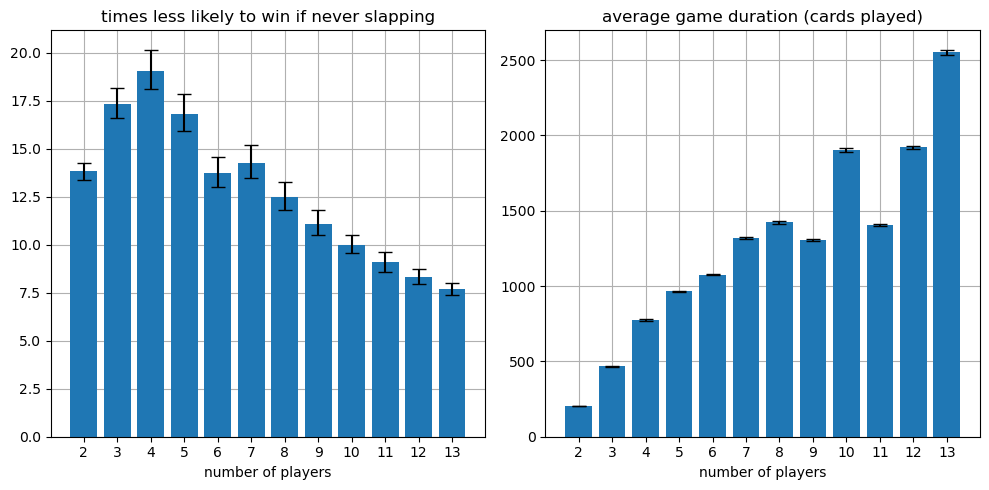

In [37]:
nx = [] # number of players
px = [] # empirical probability of winning for player 0
ex = [] # confidence interval for px
dx = [] # mean number of turns in a game
sx1 = [] # lower error for dx (bootstrap)
sx2 = [] # upper error for dx (bootstrap)

q = 0
for (N,M,counts,turns) in expt:
    q += 1
    print(q)
    nx.append( N )
    p = counts[0] / M
    z = 1.96
    px.append( np.maximum(p,1e-2) )
    ex.append( z * np.sqrt(p * (1 - p) / M + z**2 / (4 * M**2)) )
    dx.append( np.mean(turns) )
    
    
    # Number of bootstrap samples
    num_bootstraps = 1000

    # Create an array to store sample means
    bootstrap_means = np.zeros(num_bootstraps)

    # Perform bootstrapping
    for i in range(num_bootstraps):
        # Resample with replacement
        bootstrap_sample = np.random.choice(turns, size=M, replace=True)

        # Calculate the mean for the bootstrap sample
        bootstrap_means[i] = np.mean(bootstrap_sample)

    # Calculate the confidence interval
    confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])
    
    sx1.append( np.mean(turns) - confidence_interval[0] )
    sx2.append( confidence_interval[1] - np.mean(turns) )
    
    
    
rx = [1/nx[i]/px[i] for i in range(len(nx))]
erlo = [1/nx[i]/px[i] - 1/nx[i]/(px[i]+ex[i]) for i in range(len(nx))]
erhi = [1/nx[i]/(px[i]-ex[i]) - 1/nx[i]/px[i] for i in range(len(nx))]

fig,axs = plt.subplots(1,2, figsize=(10,5))

plt.sca(axs[0])
plt.bar(nx, rx, yerr=[erlo,erhi], capsize=5, zorder=2)
plt.xticks(nx)
plt.grid(zorder=1)
plt.xlabel("number of players")
plt.title("times less likely to win if never slapping")

plt.sca(axs[1])
plt.bar(nx, dx, yerr=[sx1,sx2], capsize=5, zorder=2)
plt.xticks(nx)
plt.grid(zorder=1)
plt.xlabel("number of players")
plt.title("average game duration (cards played)")

fig.tight_layout()

fig.savefig("slapx.png")

### How many cards per hand as a function of number of players?

In [113]:
[(N, 52//N) for N in range(2,14)]

[(2, 26),
 (3, 17),
 (4, 13),
 (5, 10),
 (6, 8),
 (7, 7),
 (8, 6),
 (9, 5),
 (10, 5),
 (11, 4),
 (12, 4),
 (13, 4)]